# Setup

In [1]:
import numpy as np
from numpy import random
from scipy import stats
import csv
import pickle
import matplotlib
import matplotlib.pyplot as plt
from time import time
import pandas as pd

from gensim.models import Word2Vec

from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

%matplotlib inline
matplotlib.style.use('ggplot')

Using TensorFlow backend.


In [2]:
from classification_tree import *

# Dataset

In [3]:
PATH_GLOVE   = 'GloVe-1.2/'
DATASET = 'amazon'

PATH_DATASET = '/Users/rafalencar/Documents/Datasets/Products_Catalog/'

In [4]:
readFile = open(PATH_DATASET + 'amazon_co-ecommerce_sample.csv', 'r')
reader = csv.reader(readFile)

writeFileLabeled = open(PATH_DATASET + 'amazon_co-ecommerce_sample_Dataset.csv', 'w')
writerLabeled = csv.writer(writeFileLabeled)

writeFileToLabel = open(PATH_DATASET + 'amazon_co-ecommerce_sample_NoLabel.csv', 'w')
writeToLabel = csv.writer(writeFileToLabel)
            
writeToLabel.writerow(['product_name', 'product_information', 'product_description',
                       'category', 'category_first_layer'])

for row in reader:
    label = row[8]
    if label != '':
        writerLabeled.writerow([row[1], row[11], row[12], label, label.split(' > ')[0]])
    else: 
        writeToLabel.writerow([row[1], row[11], row[12], label, label])
        
readFile.close()
writeFileLabeled.close()
writeFileToLabel.close()

In [5]:
dataset = pd.read_csv(PATH_DATASET + 'amazon_co-ecommerce_sample_Dataset.csv')
dataset = dataset.replace(np.nan, '', regex=True)

dataToLabel = pd.read_csv(PATH_DATASET + 'amazon_co-ecommerce_sample_NoLabel.csv')
dataToLabel = dataToLabel.replace(np.nan, '', regex=True)

print('Not Labeled Dataset Shape: ', dataToLabel.shape[0])
print('Labeled Dataset Shape: ', dataset.shape[0])
dataset.head(5)

Not Labeled Dataset Shape:  690
Labeled Dataset Shape:  9310


,product_name,product_information,product_description,amazon_category_and_sub_category,amazon_category_and_sub_category.1
0,Hornby 2014 Catalogue,Technical Details Item Weight640 g Product Dim...,Product Description Hornby 2014 Catalogue Box ...,Hobbies > Model Trains & Railway Sets > Rail V...,Hobbies
1,FunkyBuys® Large Christmas Holiday Express Fes...,Technical Details Manufacturer recommended age...,Size Name:Large FunkyBuys® Large Christmas Hol...,Hobbies > Model Trains & Railway Sets > Rail V...,Hobbies
2,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,Technical Details Manufacturer recommended age...,BIG CLASSIC TOY TRAIN SET TRACK CARRIAGE LIGHT...,Hobbies > Model Trains & Railway Sets > Rail V...,Hobbies
3,HORNBY Coach R4410A BR Hawksworth Corridor 3rd,Technical Details Item Weight259 g Product Dim...,Hornby 00 Gauge BR Hawksworth 3rd Class W 2107...,Hobbies > Model Trains & Railway Sets > Rail V...,Hobbies
4,Hornby 00 Gauge 0-4-0 Gildenlow Salt Co. Steam...,Technical Details Item Weight159 g Product Dim...,Product Description Hornby RailRoad 0-4-0 Gild...,Hobbies > Model Trains & Railway Sets > Rail V...,Hobbies


First Layer Labels :  43


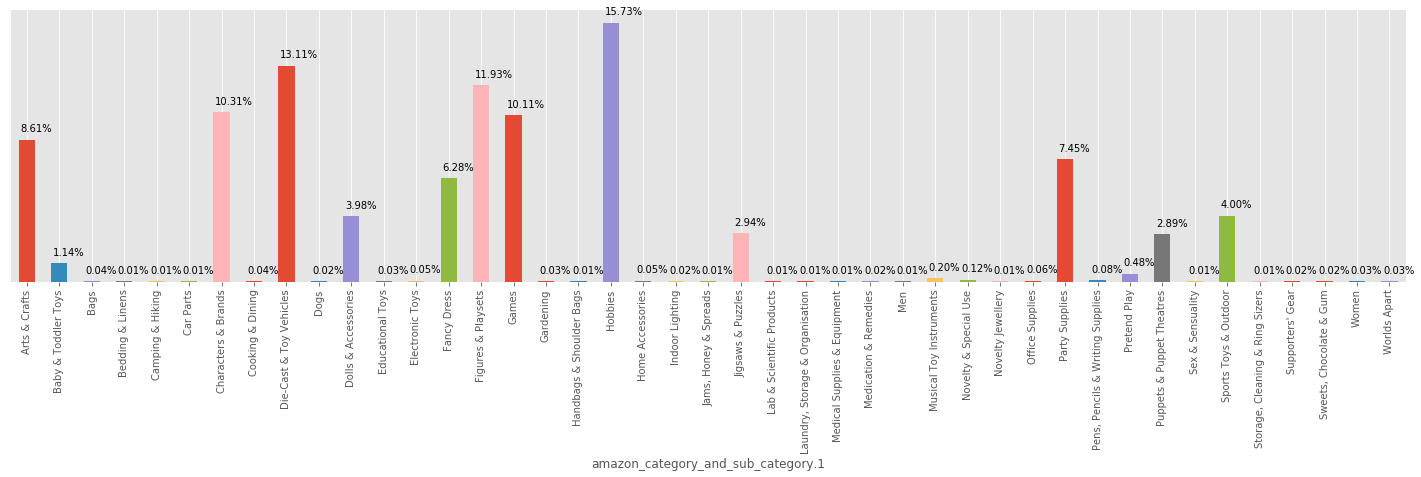

In [6]:
CATEGORY_FL = "amazon_category_and_sub_category.1"
CATEGORY    = "amazon_category_and_sub_category"

labelsFL = dataset[CATEGORY_FL].unique()
print("First Layer Labels : ", labelsFL.shape[0])
fig = plt.figure(figsize=(30,8))
count = dataset.groupby(CATEGORY_FL).product_name.count()
ax = (count.div(count.sum(), axis=0)).plot(kind='bar',figsize=(25,5),width = 0.5)

plt.xticks(fontsize=10)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.yticks([])

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.2%}'.format(height), (p.get_x()+.10*width, p.get_y() + height + 0.005))
plt.show()

All Labels with minimum 1 samples:  255


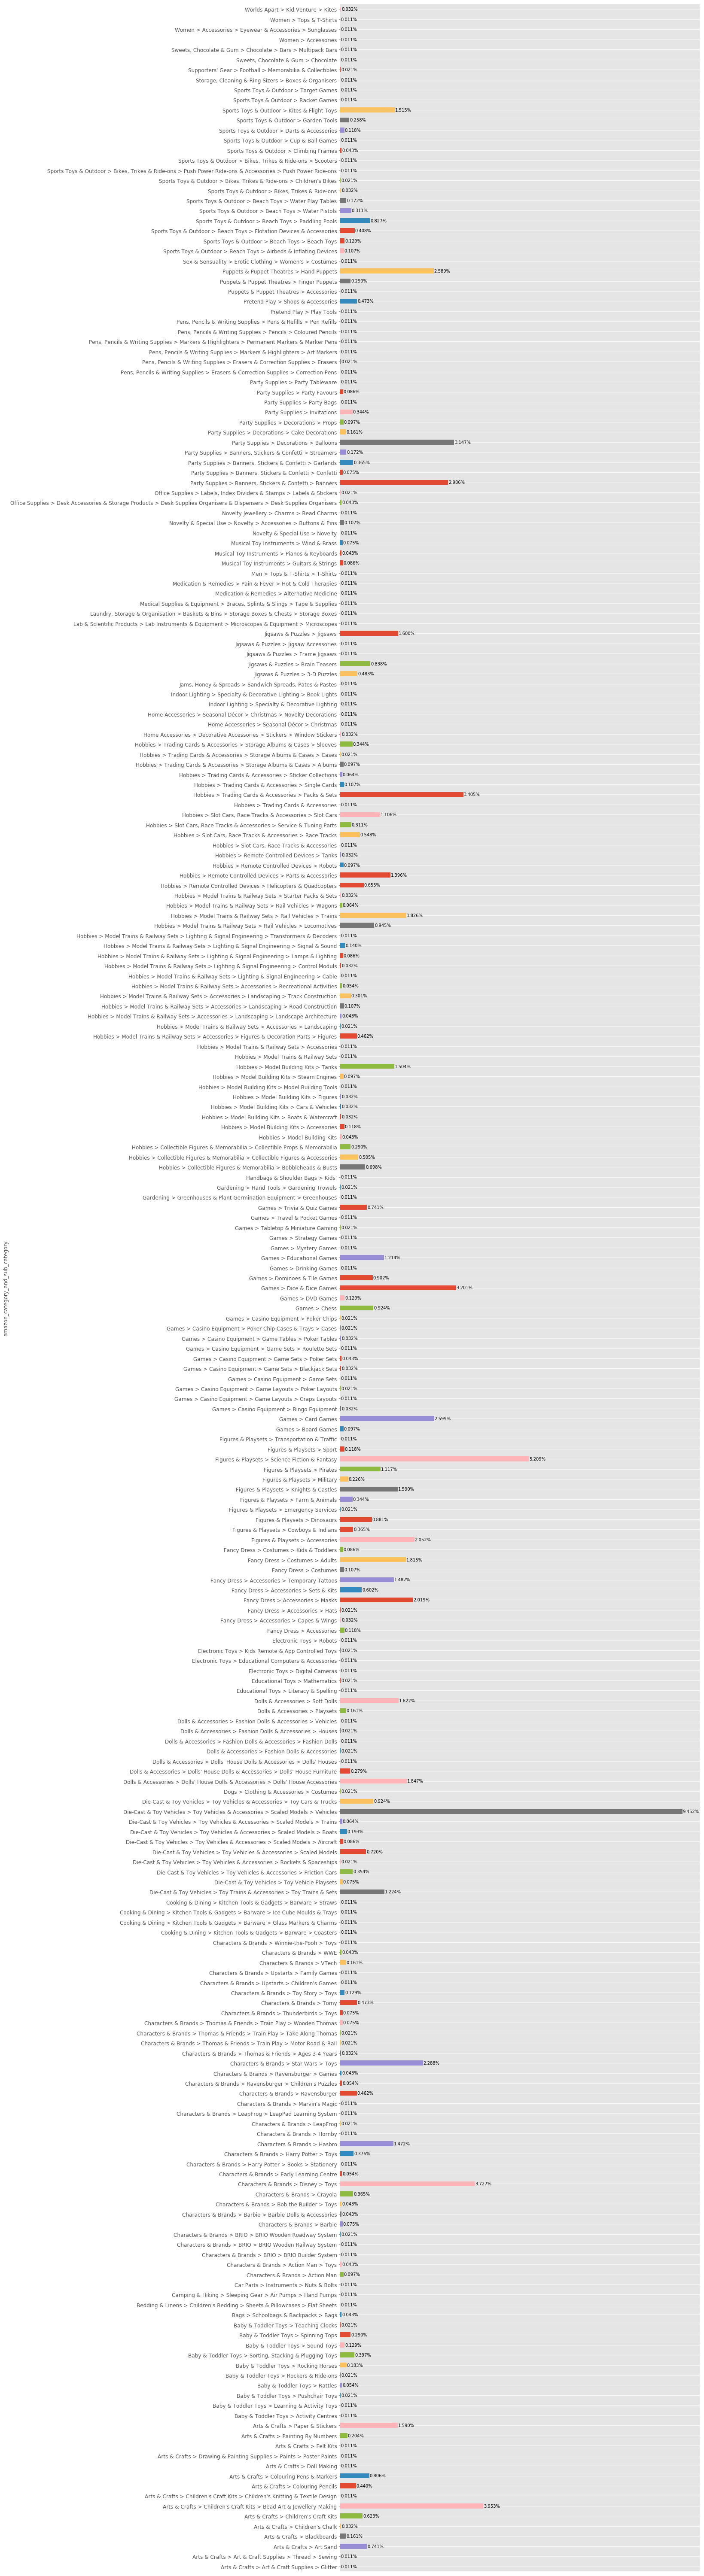

In [7]:
MIN_SAMPLES = 1
groupby = dataset.groupby(CATEGORY).product_name.count()
filtered = groupby[groupby >= MIN_SAMPLES]

#Observação, filtrar os labels pelo número de exemplares
print("All Labels with minimum %d samples: " % MIN_SAMPLES, filtered.shape[0])
fig = plt.figure(figsize=(8,20))
ax = (filtered.div(groupby.sum(), axis=0)).plot(kind='barh',figsize=(15, 110),width = 0.5)

plt.yticks(fontsize=12)
for spine in plt.gca().spines.values():
     spine.set_visible(False)
plt.xticks([])

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.3%}'.format(width), (p.get_x()+ width + .0001, p.get_y() + height*.25))

plt.show()

In [8]:
MAX_SAMPLES = 1
groupby = dataset.groupby(CATEGORY).product_name.count()
filtered = groupby[groupby <= MAX_SAMPLES]

#Observação, filtrar os labels pelo número de exemplares
print("All Labels with maximum %d samples: " % MAX_SAMPLES, filtered.shape[0])

All Labels with maximum 1 samples:  84


In [9]:
datasetFilt = dataset[~dataset[CATEGORY].isin(filtered.index)]
labels = datasetFilt[CATEGORY].unique()
LABELS = labels.shape[0]
print("Total Filtered Labels: ", labels.shape[0])

Total Filtered Labels:  171


Mode Description Length: 0 with 618 samples
Mean Description Length:  66.29
Std Description Length:  94.57
Max Description Length:  6164
Min Description Length:  0
S/W Description Ratio:  140


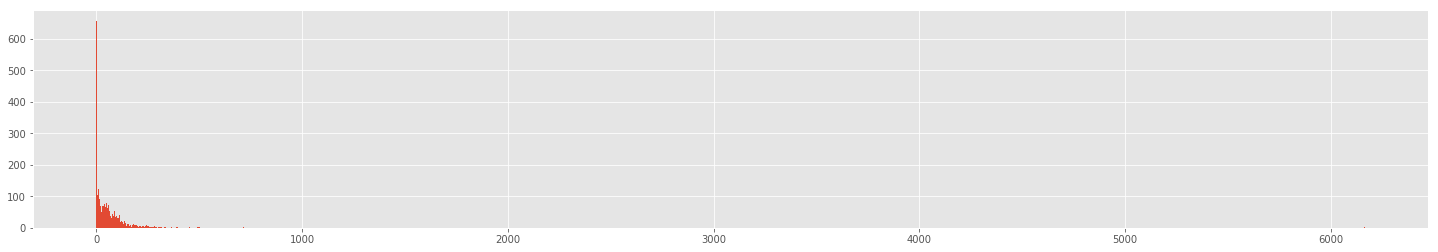

In [10]:
descr_size = []
X_used = "product_description"
for item in dataset[X_used]:
    split = item.split()
    descr_size.append(len(split))

mode = stats.mode(descr_size)
mean = np.mean(descr_size)
std  = np.std(descr_size)
maxL = max(descr_size)
minL = min(descr_size)

ratio = dataset.shape[0]/mean

print('Mode Description Length:', mode.mode[0], 'with', mode.count[0], 'samples') 
print('Mean Description Length: ', round(mean,2))  
print('Std Description Length: ', round(std,2))
print('Max Description Length: ', maxL)  
print('Min Description Length: ', minL) 
print('S/W Description Ratio: ', int(ratio)) 

plt.figure(figsize=(25,4))
plt.hist(descr_size, bins=maxL-1)
plt.show()

Mode Description Length: 91 with 258 samples
Mean Title Length:  111.6
Std Title Length:  61.31
Max Title Length:  400
Min Title Length:  0
S/W Title Ratio:  83


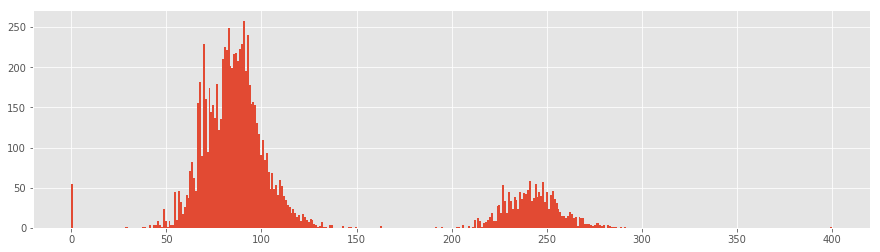

In [11]:
info_size = []
X_used = "product_information"
for item in dataset[X_used]:
    split = item.split()
    info_size.append(len(split))
    
mode = stats.mode(info_size)
mean = np.mean(info_size)
std  = np.std(info_size)
maxL = max(info_size)
minL = min(info_size)

ratio = dataset.shape[0]/mean
  
print('Mode Description Length:', mode.mode[0], 'with', mode.count[0], 'samples')   
print('Mean Title Length: ', round(mean,2)) 
print('Std Title Length: ', round(std,2))  
print('Max Title Length: ', maxL)  
print('Min Title Length: ', minL)  
print('S/W Title Ratio: ', int(ratio))

plt.figure(figsize=(15,4))
plt.hist(info_size, bins=maxL-1)
plt.show()

Mode Description Length: 7 with 1031 samples
Mean Title Length:  9.0
Std Title Length:  4.73
Max Title Length:  104
Min Title Length:  1
S/W Title Ratio:  1033


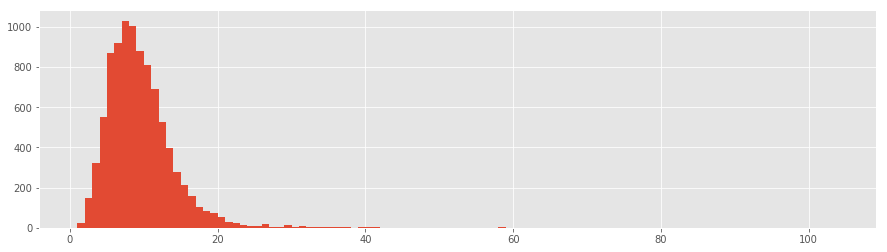

In [12]:
title_size = []
X_used = "product_name"
for item in dataset[X_used]:
    split = item.split()
    title_size.append(len(split))
    
mode = stats.mode(title_size)
mean = np.mean(title_size)
std  = np.std(title_size)
maxL = max(title_size)
minL = min(title_size)

ratio = dataset.shape[0]/mean
  
print('Mode Description Length:', mode.mode[0], 'with', mode.count[0], 'samples')   
print('Mean Title Length: ', round(mean,2)) 
print('Std Title Length: ', round(std,2))  
print('Max Title Length: ', maxL)  
print('Min Title Length: ', minL)  
print('S/W Title Ratio: ', int(ratio))

plt.figure(figsize=(15,4))
plt.hist(title_size, bins=maxL-1)
plt.show()

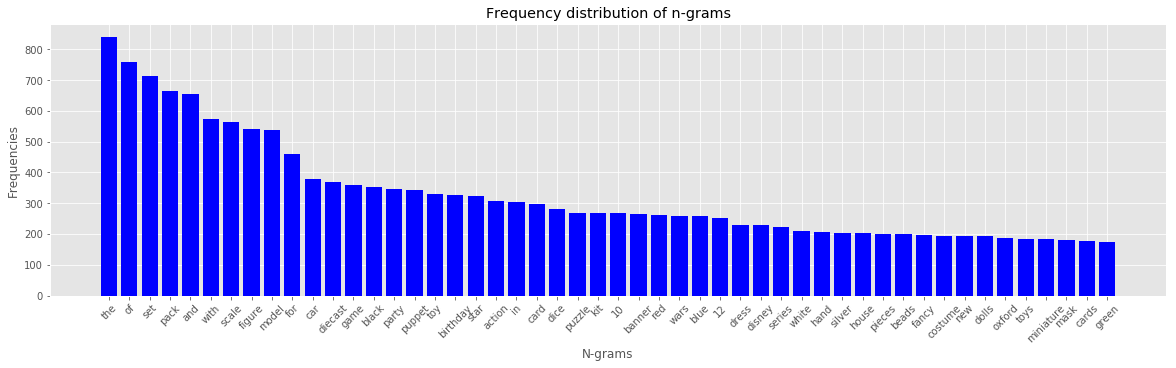

In [13]:
def plot_frequency_distribution_of_ngrams(sample_texts, ngram_range=(1, 2), num_ngrams=50):
    # Create args required for vectorizing.
    kwargs = {
            'ngram_range': (1, 1),
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
    }
    vectorizer = CountVectorizer(**kwargs)
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary.
    all_ngrams = list(vectorizer.get_feature_names())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    # ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]

    idx = np.arange(num_ngrams)
    plt.figure(figsize=(20,5))
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('N-grams')
    plt.ylabel('Frequencies')
    plt.title('Frequency distribution of n-grams')
    plt.xticks(idx, ngrams, rotation=45)
    plt.show()
    
plot_frequency_distribution_of_ngrams(dataset[X_used], ngram_range=(1, 2), num_ngrams=50)

In [14]:
labels = dataset[CATEGORY].unique()
LABELS = labels.shape[0]
print("Total Labels: ", labels.shape[0])

Total Labels:  255


# Embedding

### Save Data Models

In [27]:
X_used = 'product_information'
dataX = dataset[X_used]

if X_used == 'product_name': 
    MAX_SEQUENCE_LENGTH = 1.1*max(title_size) 
elif X_used == 'product_description':  
    MAX_SEQUENCE_LENGTH = 1.1*max(descr_size)
else:
    MAX_SEQUENCE_LENGTH = 1.1*max(info_size)

In [28]:
EMBEDDING_DIM = 100

PATH_DATA_MODELS   = 'data_models/'

FILE_WORD2VEC      = PATH_DATA_MODELS + DATASET + '_' + X_used +'_word2vec_s' + str(EMBEDDING_DIM) + '.model'
FILE_TOKENIZER     = PATH_DATA_MODELS + DATASET + '_' + X_used +'_tokenizer.sav'
FILE_VECTORIZER    = PATH_DATA_MODELS + DATASET + '_' + X_used +'_vectorizer.sav'
FILE_LABEL_ENCODER = PATH_DATA_MODELS + DATASET +'_label_encoder.sav'

### Word2Vec

In [29]:
sentences = []
for item in dataX:
    split = item.split()
    sentences.append(split)
    
start = time()
word2vec = Word2Vec(sentences, size=EMBEDDING_DIM)#, window=5, min_count=1, workers=4)
print("Execution Time:", round(time() - start, 2), 's')
print("Number of Word Vectors:", len(list(word2vec.wv.vocab)))

# Save Word2Vec
word2vec.save(FILE_WORD2VEC)

Execution Time: 3.3 s
Number of Word Vectors: 2092


### Tokenizer

In [30]:
MAX_NB_WORDS = 20000
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(dataX)
print("Number of Tokens:",len(tokenizer.word_counts))

# Save Tokenizer
pickle.dump(tokenizer, open(FILE_TOKENIZER, 'wb'))

Number of Tokens: 24258


### Vectorizer

In [31]:
MAX_NB_WORDS = 20000
vectorizer  = TfidfVectorizer(max_features=MAX_NB_WORDS, stop_words='english')
vectorizer.fit(dataX)

# Save Vectorizer
pickle.dump(vectorizer, open(FILE_VECTORIZER, 'wb'))

### Label Encoder

In [20]:
le = preprocessing.LabelEncoder()
le.fit(labels)

# Save Label Encoder 
pickle.dump(le, open(FILE_LABEL_ENCODER, 'wb'))

# Classification Tree

In [26]:
tree = Tree('Root')    
for label in labels:
    split = label.split(' > ')
    tree = tree.populateTree(split, 0)

In [28]:
x_train = dataX
y_train = dataset[CATEGORY]
tree.sampleTree(x_train, y_train, 0)
print()

 > Root Samples: 9310 Nodes 43
|   > Hobbies Samples: 1464 Nodes 6
|  |   > Model Trains & Railway Sets Samples: 387 Nodes 4
|  |  |   > Rail Vehicles Samples: 264 Nodes 3
|  |  |  |   > Trains Samples: 170 Nodes 0
|  |  |  |   > Locomotives Samples: 88 Nodes 0
|  |  |  |   > Wagons Samples: 6 Nodes 0
|  |  |   > Lighting & Signal Engineering Samples: 26 Nodes 5
|  |  |  |   > Lamps & Lighting Samples: 8 Nodes 0
|  |  |  |   > Signal & Sound Samples: 13 Nodes 0
|  |  |  |   > Transformers & Decoders Samples: 1 Nodes 0
|  |  |  |   > Control Moduls Samples: 3 Nodes 0
|  |  |  |   > Cable Samples: 1 Nodes 0
|  |  |   > Accessories Samples: 93 Nodes 3
|  |  |  |   > Recreational Activities Samples: 5 Nodes 0
|  |  |  |   > Landscaping Samples: 44 Nodes 3
|  |  |  |  |   > Landscape Architecture Samples: 4 Nodes 0
|  |  |  |  |   > Track Construction Samples: 28 Nodes 0
|  |  |  |  |   > Road Construction Samples: 10 Nodes 0
|  |  |  |   > Figures & Decoration Parts Samples: 43 Nodes 1
|  

|   > Sweets, Chocolate & Gum Samples: 2 Nodes 1
|  |   > Chocolate Samples: 2 Nodes 1
|  |  |   > Bars Samples: 1 Nodes 1
|  |  |  |   > Multipack Bars Samples: 1 Nodes 0
|   > Sports Toys & Outdoor Samples: 372 Nodes 9
|  |   > Beach Toys Samples: 182 Nodes 6
|  |  |   > Beach Toys Samples: 12 Nodes 0
|  |  |   > Airbeds & Inflating Devices Samples: 10 Nodes 0
|  |  |   > Water Pistols Samples: 29 Nodes 0
|  |  |   > Paddling Pools Samples: 77 Nodes 0
|  |  |   > Water Play Tables Samples: 16 Nodes 0
|  |  |   > Flotation Devices & Accessories Samples: 38 Nodes 0
|  |   > Bikes, Trikes & Ride-ons Samples: 7 Nodes 3
|  |  |   > Scooters Samples: 1 Nodes 0
|  |  |   > Children's Bikes Samples: 2 Nodes 0
|  |  |   > Push Power Ride-ons & Accessories Samples: 1 Nodes 1
|  |  |  |   > Push Power Ride-ons Samples: 1 Nodes 0
|  |   > Kites & Flight Toys Samples: 141 Nodes 0
|  |   > Garden Tools Samples: 24 Nodes 0
|  |   > Darts & Accessories Samples: 11 Nodes 0
|  |   > Climbing Frames Sa

|   > Novelty Jewellery Samples: 1 Nodes 1
|  |   > Charms Samples: 1 Nodes 1
|  |  |   > Bead Charms Samples: 1 Nodes 0

